 Short Selling on Exxon Mobil - MA Strategy
- Author Kobby Amoah

 This notebook implements the following strategy:
 
         -  Moving Average Price with Volatility Bands on the Exxon Mobil Stock('XOM')

- Inspired by Work from Laurent Bernut

Disclosure: Some of the code uses work done Laurent Bernut. Roughly speaking his code is about 40% of the work. The strategy and it's development however is all my work.

Goal of the Notebook:
    While the notebook implements a technical analysis trend-following strategy, it's core is concerned with systematic trading rules. In particular these are the questions that guide this notebook 
 
1.   What trading styles are available?    - Used a trend following strategy
2.   What makes a good trading rule? 
3.   When does the rule work and why does it work? 
4.   When does the rule not work and how much do you stand to lose? 
5.   How successful should you expect to be by trading that rule?
6.   How would this rule fare when you have a limit on how much you can lose?

To answer the above, the notebook is organized as follows:

 Code Organization & Functions 

- Section 1.  Library Imports

- Section 2.  Data Imports and Conversion to Relative Price Series 
 
- Section 3.  Moving Average Strategy 

- Section 4.  Gain Expectancies   (Answers Questions 2 & 3)

- Section 5.  Risk Management & Performance Metrics   (Answers Question 6)
                     
- Section 6.  Drawdown         (Answers Question 4)

- Section 7:  Summary (Strategy Stats)   (Answers Question 5)

 Logic of the Strategy:

 - Enter when today's price exceeds the   MA price + s * atr 
 
 - Exit when today's price goes below the MA price - s * stdev
 - Else maintain your prior position

 atr = average true range, and s = scaling factor

Code Organization & Functions - Section 1:
1. Library Imports

In [28]:
# Library Imports
import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import quandl
import scipy.stats as scs
from sklearn.linear_model import LinearRegression

pd.options.display.max_columns=20
pd.options.display.max_rows=20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True)

 Code Organization & Functions - Section 2:

  2. Data Imports and Conversion to Relative Price Series
         a. Functions for Data Import and Conversion
                 - relative : generates relative price series given the absolute 
                           price series.

relative price =  (current closing stock price/current benchmark price) * first value of                        benchmark in the series 

                 - lower_upper_OHLC : returns string list [ _o,_h,_l,_c ] used to access 
                          relative and absolute prices from dataframe.

In [2]:
### RELATIVE PRICE SERIES
def relative(df,_o,_h,_l,_c, bm_df, bm_col, dgt, start, end):
    '''
    df: df
    bm_df, bm_col:  benchmark dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end] 
    
    # inner join of benchmark: only common values are preserved
    df = df.join(bm_df[[bm_col]],how='inner') 

    # rename benchmark name as bm
    df.rename(columns={bm_col:'bm'},inplace=True)

    # Divide absolute price by benchmark and multiply by first value of benchmark
    df['r' + str(_o)] = round(df[_o].div(df['bm'])*df['bm'][0] ,dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bm'])*df['bm'][0] ,dgt)
    df['r'+ str(_l)] = round(df[_l].div(df['bm'])*df['bm'][0] ,dgt)
    df['r'+ str(_c)] = round(df[_c].div(df['bm'])*df['bm'][0] ,dgt)
    df = df.drop(['bm'],axis=1)
    
    return (df)

* Note the relative price series is only for signal generation not for performance measurement.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


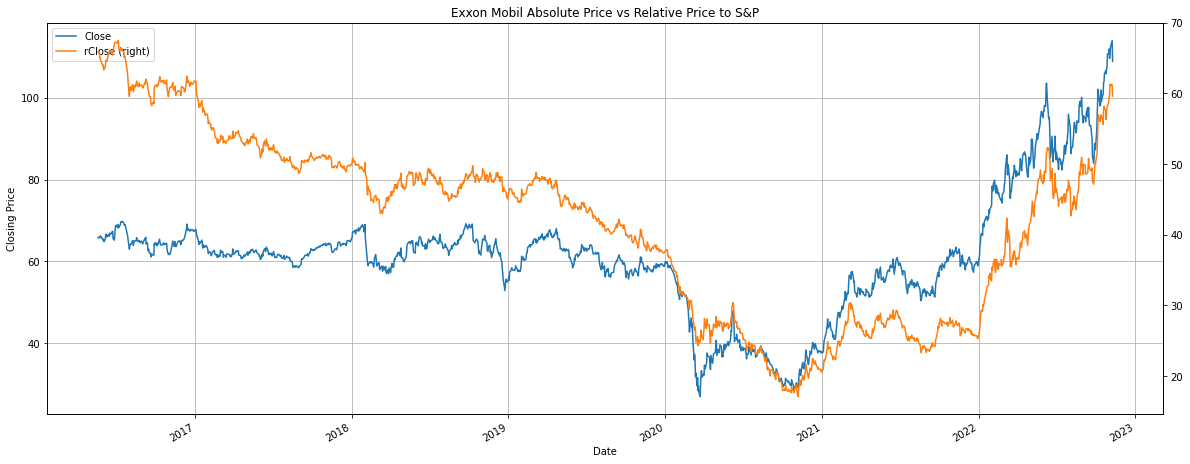

In [3]:
# Download price data for Exxon mobil
# Calculate Relative price series with S&P as benchmark

params = ['2016-5-20', None, 0.05, 0.05, 1.5, 2]
start, end ,dist_pct,retrace_pct,threshold,dgt= [params[h] for h in range(len(params))]

ticker = 'XOM' # Exxon Mobil
ohlc = ['Open','High','Low','Close']
_o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
df =  round(yf.download(tickers= ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None),2)
bm_df = pd.DataFrame()
bm_ticker = '^GSPC' #S&P
bm_col = 'S&P'
dgt = 2

bm_df[bm_col] =  yf.download(tickers= bm_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close']

df = relative(df,_o,_h,_l,_c, bm_df, bm_col, dgt, start, end)

# Plot the closing absolute and relative price series
df[['Close','rClose']].plot(figsize=(20,8),grid=True,secondary_y= 'rClose',ylabel='Closing Price',
            title= 'Exxon Mobil Absolute Price vs Relative Price to S&P' );

In [4]:
def lower_upper_OHLC(df,relative = False):
    if relative==True:
        rel = 'r'
    else:
        rel= ''      
    if 'Open' in df.columns:
        ohlc = [rel+'Open',rel+'High',rel+'Low',rel+'Close']       
    elif 'open' in df.columns:
        ohlc = [rel+'open',rel+'high',rel+'low',rel+'close']
        
    try:
        _o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
    except:
        _o=_h=_l=_c= np.nan
    return _o,_h,_l,_c

 Code Organization & Functions - Section 3

3.  MA Strategy 
         a. Functions for Strategy 
         * Main function/ Signal Generator is regime_ma
                 - regime_ma :  Calculates moving average prices with volatility bands
                                using either simple moving average
                                or exponential moving average.            

In [29]:
#### Rg_SMA = Vol. bands using simple moving average
###  RG_EMA  = Vol. bands using exponential moving average####

def average_true_range(df, _h, _l, _c, n):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    '''
    # Combine the high and close into one data frame and take the max of the 2 values.
    # TR = max(high,previous_close)- min(low,previous_close)
    atr =  (df[_h].combine(df[_c].shift(), max) - df[_l].combine(df[_c].shift(), min)).rolling(window=n).mean()
    return atr

# Default is to use Simple Moving Average
# Uses Exponential Moving Average when EMA is set to TRUE
def regime_ma(df,_c,days, s=2,ema= False):
    '''
    _c = closing price, s= scaling factor, default = 2
    bull +1: _c >= sma + s* atr , bear -1: _c <= sma - s*stdev,
    else maintain your prior position
    '''
    sma = df[_c].rolling(days).mean()
    sma_stdev = df[_c].rolling(days).std()
    # Note I use the Average True Range for the top vol. band
    atr = average_true_range(df, _h, _l, _c, n=days)
    sma_bull = sma+ s *  atr
    sma_bear = sma - s * sma_stdev
    rg_sma = np.where(df[_c]>  sma_bull, 1,
                     np.where(df[_c]< sma_bear, -1,np.nan))  
    rg_ma = pd.Series(index= df.index, data = rg_sma).fillna(method = 'ffill')

    if ema == True:
        ema = df[_c].ewm(span = days, min_periods=days).mean() 
        ema_stdev = df[_c].ewm(span = days, min_periods=days).std() 
        # Note I use the Average True Range for the top vol. band
        atr = average_true_range(df, _h, _l, _c, n=days)
        ema_bull = ema + s * atr
        ema_bear = ema - s * ema_stdev
        rg_ema = np.where(df[_c]>  ema_bull, 1,
                         np.where(df[_c]< ema_bear, -1,np.nan))
        rg_ma = pd.Series(index= df.index, data = rg_ema).fillna(method = 'ffill')
    return rg_ma


days=50
# ohlc = ['Open','High','Low','Close']
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

df['ma_' + str(days)] = regime_ma(df,_c,days,s=2,ema=True)

# relative ohlc = ['rOpen','rHigh','rLow','rClose']
_o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
df['rma_' + str(days)] = regime_ma(df,_c,days,s=2,ema=True)

This implementation uses the Exponential Moving Average.

Signal is given by 'ma_' + str(days)  for absolute price series

Signal is given by 'rma_' + str(days)  for relative price series

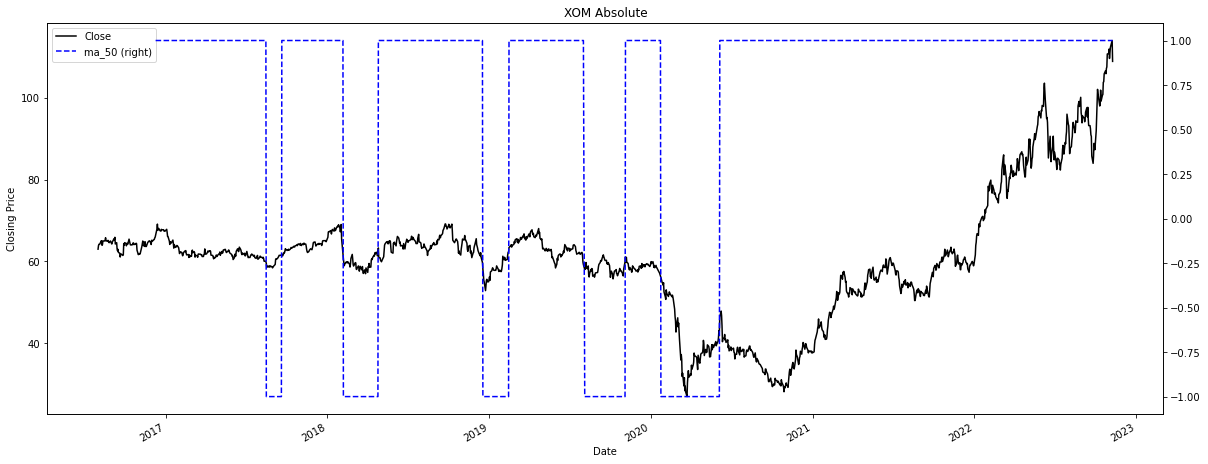

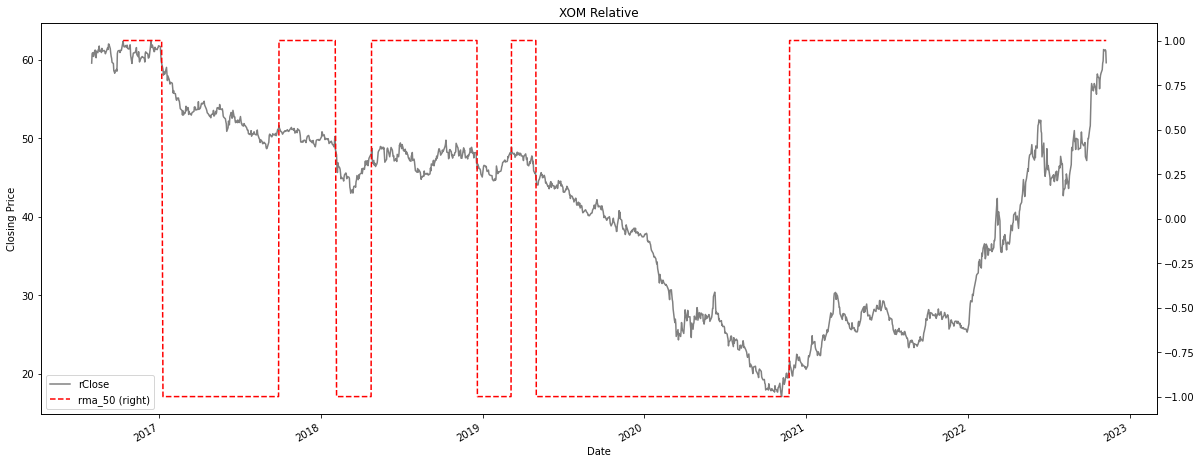

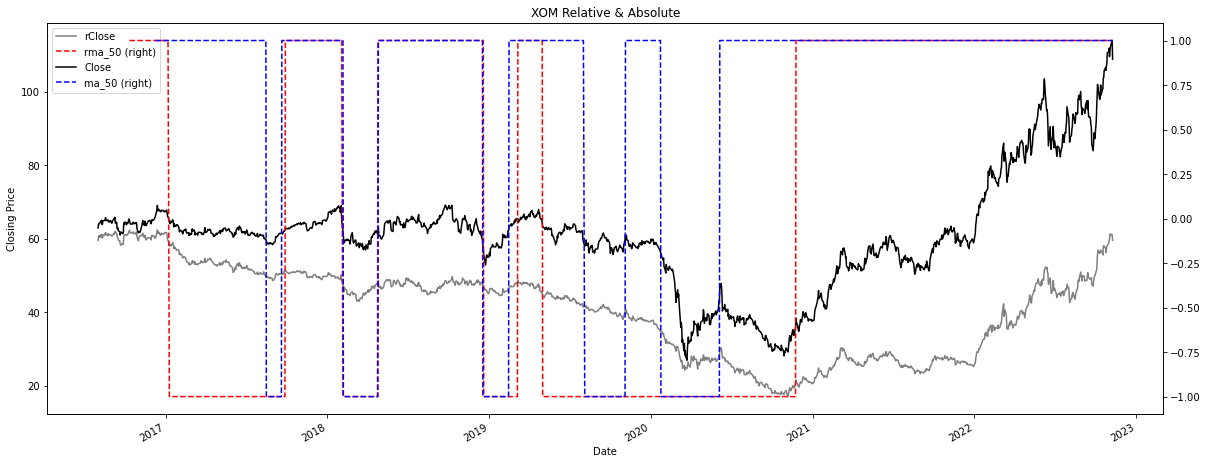

In [30]:
plot_abs_cols =  ['Close','ma_' + str(days)]
plot_abs_style = ['k', 'b--']
y2_abs = ['ma_' + str(days)]
plot_rel_cols = ['rClose','rma_' + str(days)]
plot_rel_style = ['grey', 'r--']
y2_rel = ['rma_' + str(days)]
df[plot_abs_cols].plot(secondary_y= y2_abs,figsize=(20,8),
            title = str.upper(ticker)+ ' Absolute',ylabel='Closing Price',
            style=plot_abs_style)

df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(20,8),
            title = str.upper(ticker)+ ' Relative',ylabel='Closing Price',
            style= plot_rel_style)

df[plot_rel_cols + plot_abs_cols].plot(secondary_y=y2_rel + y2_abs,figsize=(20,8),
            title = str.upper(ticker)+ ' Relative & Absolute',ylabel='Closing Price',
            style=plot_rel_style + plot_abs_style);

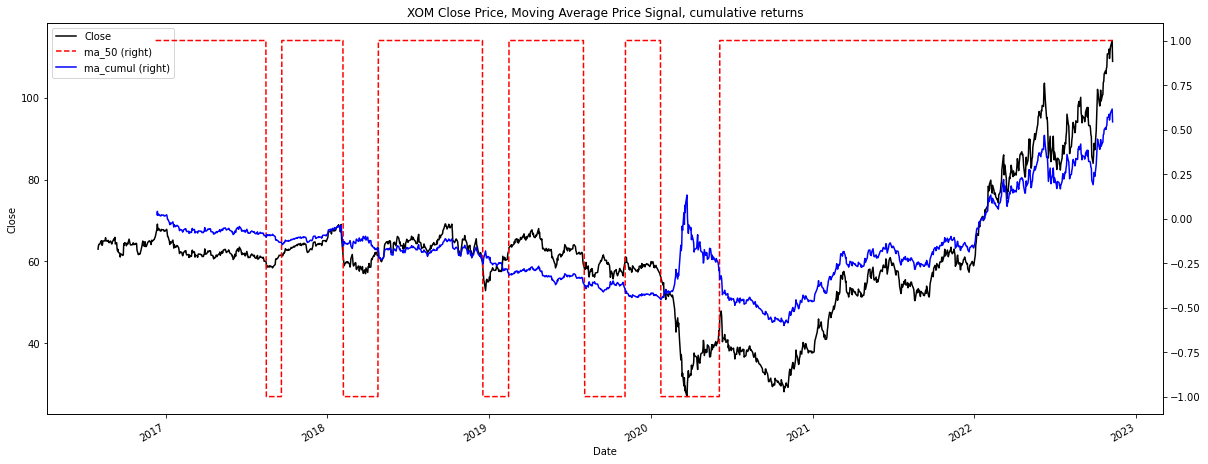

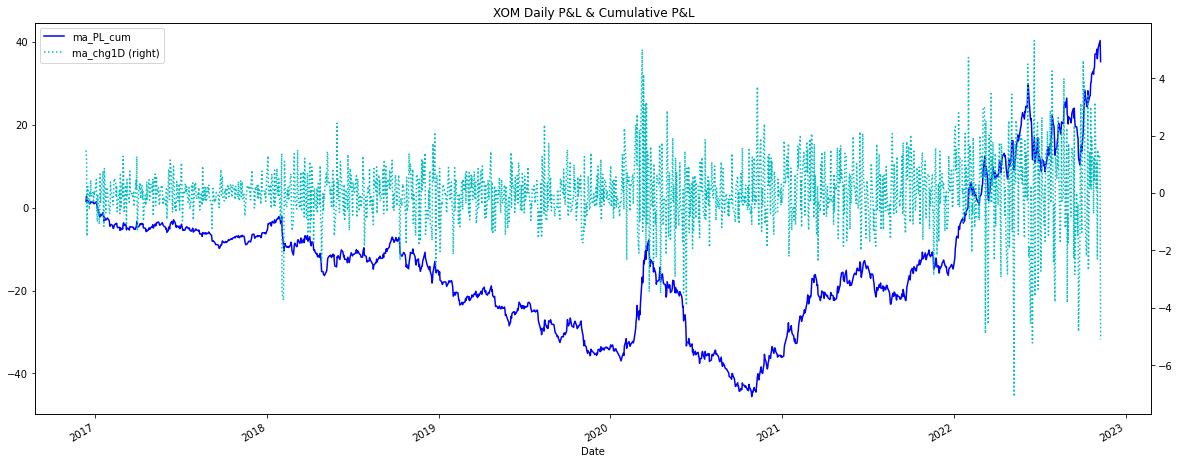

In [31]:
# Returns for Absolute Price Series
'''
ma_chg1D = daily P&L          , ma_cumul = cumulative returns
ma_PL_cum = cumulative P&L    , 'ma_' + str(days) = signal
ma_returns = daily returns
ma_log_returns = daily log returns
'''
df['ma_chg1D'] = df['Close'].diff() * df['ma_' + str(days)].shift()
df['ma_PL_cum'] = df['ma_chg1D'].cumsum()

df['ma_returns'] = df['Close'].pct_change() * df['ma_' + str(days)].shift()
ma_log_returns = np.log(df['Close']/df['Close'].shift()) * df['ma_' + str(days)].shift()
df['ma_cumul'] = ma_log_returns.cumsum().apply(np.exp) - 1 

df[['Close','ma_' + str(days),'ma_cumul']].plot(secondary_y=['ma_' + str(days),'ma_cumul'],
                                  figsize=(20,8),style= ['k','r--','b'],ylabel='Close', 
                       title= str(ticker)+' Close Price, Moving Average Price Signal, cumulative returns')

df[['ma_PL_cum','ma_chg1D']].plot(secondary_y=['ma_chg1D'],
                                  figsize=(20,8),style= ['b','c:'],
                                 title= str(ticker) +' Daily P&L & Cumulative P&L');

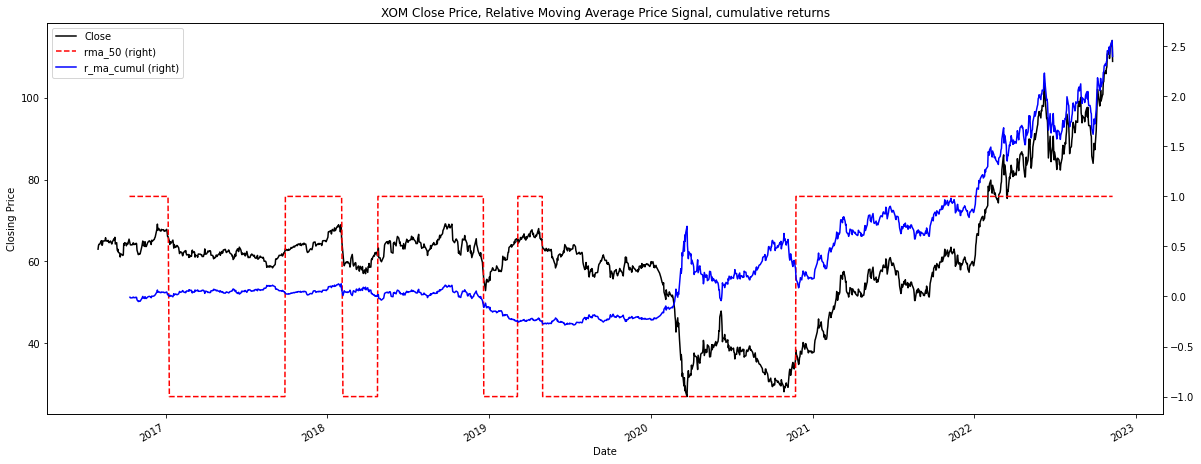

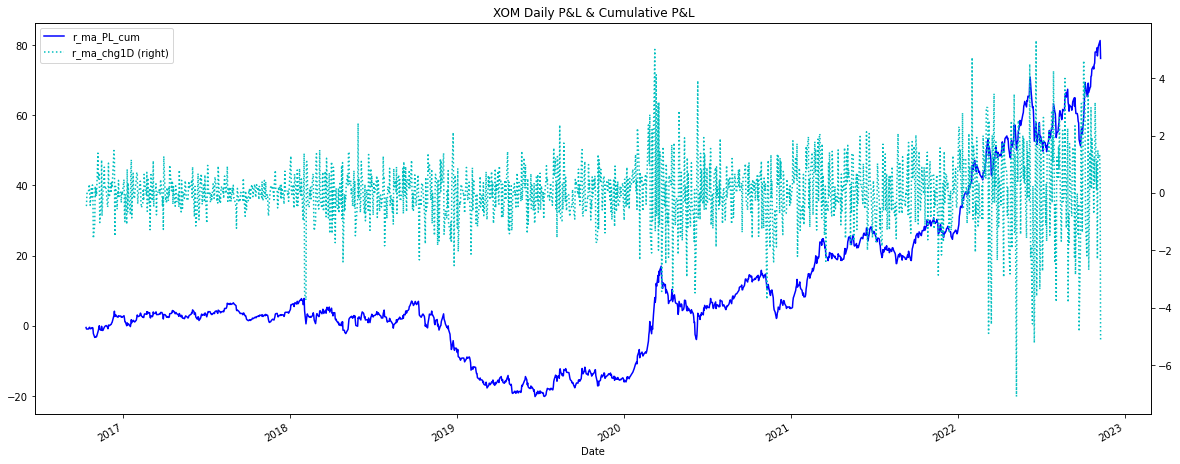

In [32]:
# Returns for Relative Price Series
df['r_ma_chg1D'] = df['Close'].diff() * df['rma_' + str(days)].shift()
df['r_ma_PL_cum'] = df['r_ma_chg1D'].cumsum()

df['r_ma_returns'] = df['Close'].pct_change() * df['rma_' + str(days)].shift()
rma_log_returns = np.log(df['Close']/df['Close'].shift()) * df['rma_' + str(days)].shift()
df['r_ma_cumul'] = rma_log_returns.cumsum().apply(np.exp) - 1 


df[['Close','rma_' + str(days),'r_ma_cumul']].plot(secondary_y=['rma_' + str(days),'r_ma_cumul'],
                                  figsize=(20,8),style= ['k','r--','b'], ylabel='Closing Price',
                       title= str(ticker)+' Close Price, Relative Moving Average Price Signal, cumulative returns')

df[['r_ma_PL_cum','r_ma_chg1D']].plot(secondary_y=['r_ma_chg1D'],
                                  figsize=(20,8),style= ['b','c:'],
                                 title= str(ticker) +' Daily P&L & Cumulative P&L');

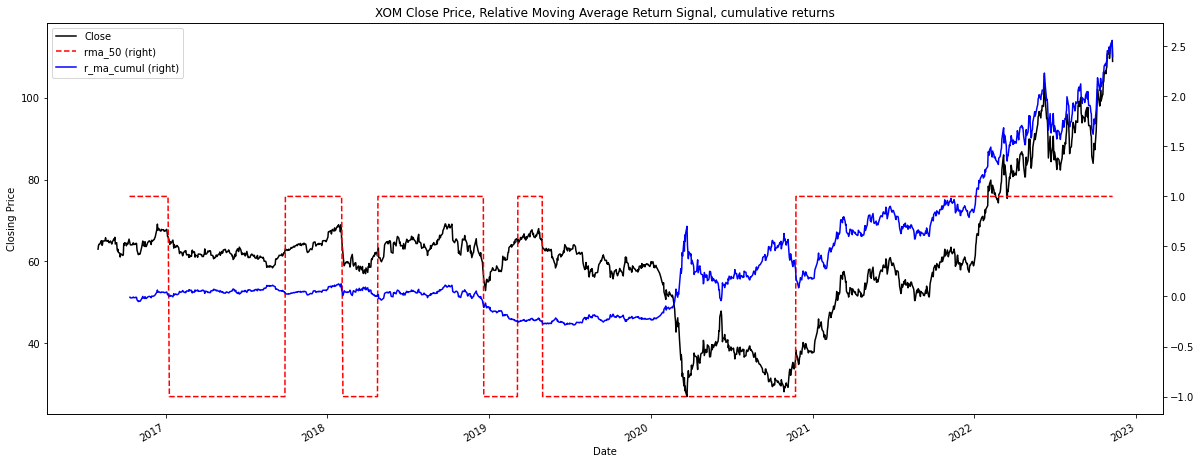

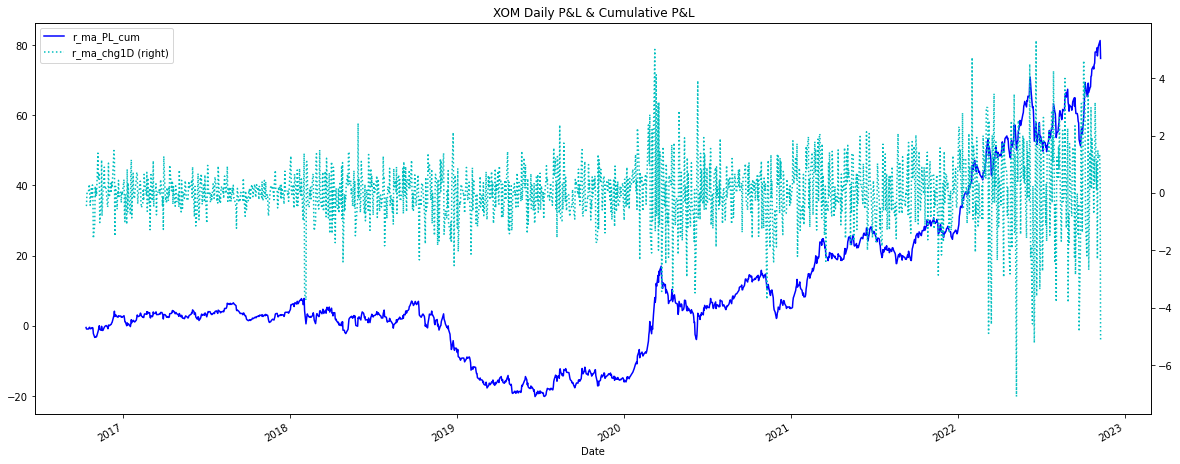

In [33]:
# Returns for Relative Return Series
df['r_ma_chg1D'] = df['Close'].diff() * df['rma_' + str(days)].shift()
df['r_ma_PL_cum'] = df['r_ma_chg1D'].cumsum()

df['r_ma_returns'] = df['Close'].pct_change() * df['rma_' + str(days)].shift()
rma_log_returns = np.log(df['Close']/df['Close'].shift()) * df['rma_' + str(days)].shift()
df['r_ma_cumul'] = rma_log_returns.cumsum().apply(np.exp) - 1 


df[['Close','rma_' + str(days),'r_ma_cumul']].plot(secondary_y=['rma_' + str(days),'r_ma_cumul'],
                                  figsize=(20,8),style= ['k','r--','b'], ylabel='Closing Price',
                       title= str(ticker)+' Close Price, Relative Moving Average Return Signal, cumulative returns')

df[['r_ma_PL_cum','r_ma_chg1D']].plot(secondary_y=['r_ma_chg1D'],
                                  figsize=(20,8),style= ['b','c:'],
                                 title= str(ticker) +' Daily P&L & Cumulative P&L');

Note the relative series P&L is on the left. The absolute price series P&L is on the right.

The relative price series blows the absolute price series out of the water throughout the period. 

A printout of their last P&L's is provided below.

In [34]:
df[['r_ma_PL_cum','ma_PL_cum']].iloc[-1]

r_ma_PL_cum    76.20
ma_PL_cum      35.17
Name: 2022-11-09 00:00:00, dtype: float64

You would have made more money using the relative. 

As a result, the implementation below uses the relative price series for signal generation.

* Code Organization & Functions - Section 4

4. Gain Expectancies
       Expectancy - Arithmetic Gain Expectancy: Calculates the arithmetic 
                                                average of the amount you 
                                                can expect to win (or lose) per trade 
                                                with the strategy.

        George    - Geometric Gain Expectancy: Calculates the geometric 
                                               average of the amount you 
                                               can expect to win (or lose) 
                                               per trade with the strategy.

         Kelly    - Kelly Criterion : Calculates the optimal position size that 
                                      maximizes the geometric growth rate 
                                      of the strategy. 

In [35]:
# Gain expectancies and Kelly criterion 
def expectancy(win_rate,avg_win,avg_loss):  
    # win% * avg_win% - loss% * abs(avg_loss%) 
    return win_rate * avg_win + (1-win_rate) * np.abs(avg_loss)
     
def george(win_rate,avg_win,avg_loss):  
    # (1+ avg_win%)** win% * (1- abs(avg_loss%)) ** loss%  -1 
    return (1+avg_win) ** win_rate * (1 + np.abs(avg_loss)) ** (1 - win_rate) - 1  
     
def kelly(win_rate,avg_win,avg_loss):  
    # Kelly = win% / abs(avg_loss%) - loss% / avg_win% 
    return win_rate / np.abs(avg_loss) - (1-win_rate) / avg_win

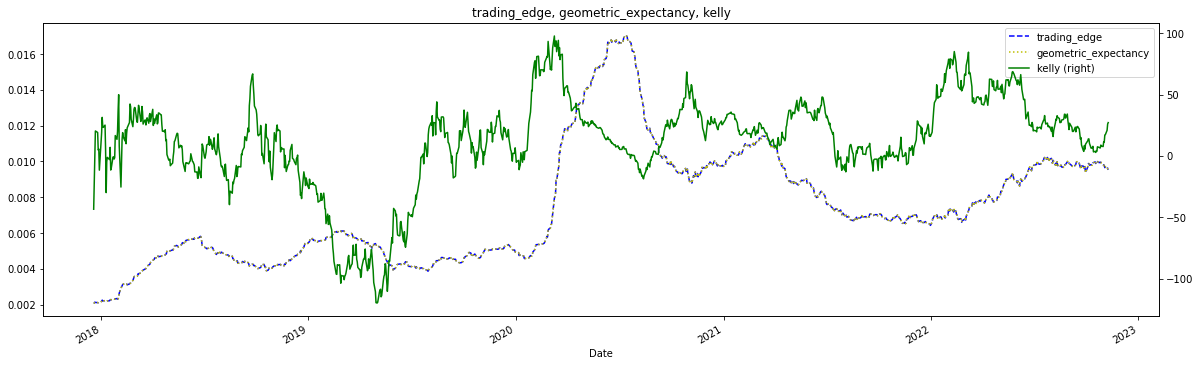

In [82]:
# Separate profits from losses
loss_roll = rma_log_returns.copy()   # This uses the absolute price series
loss_roll[loss_roll > 0] = np.nan
win_roll = rma_log_returns.copy()
win_roll[win_roll < 0] = np.nan

# Calculate rolling win/loss rates and averages
window= 100
win_rate = win_roll.rolling(window,min_periods=0 ).count() / window
loss_rate = loss_roll.rolling(window,min_periods=0 ).count() / window
avg_win = win_roll.fillna(0).rolling(window,min_periods=0 ).mean()
avg_loss = loss_roll.fillna(0).rolling(window,min_periods=0 ).mean()

# Calculate cumulative win/loss rates and averages
cum_win_rate = win_roll.expanding().count() / len(rma_log_returns.dropna())
cum_loss_rate = loss_roll.expanding().count() / len(rma_log_returns.dropna())
cum_avg_win = win_roll.fillna(0).expanding().mean()
cum_avg_loss = loss_roll.fillna(0).expanding().mean()

# Calculate expectancies
df['trading_edge'] = expectancy(win_rate,avg_win,avg_loss).fillna(method='ffill')
df['geometric_expectancy'] = george(win_rate,avg_win,avg_loss).fillna(method='ffill')
df['kelly'] = kelly(win_rate,avg_win,avg_loss).fillna(method='ffill')

df[window*3:][['trading_edge', 'geometric_expectancy', 'kelly']].plot(
    secondary_y = ['kelly'], figsize=(20,6),style=['b--','y:','g'], 
    title= 'trading_edge, geometric_expectancy, kelly');

Why are the trading_edge and geometric expectancy not showing properly on the graph?

   Trading_edge and geometric_expectancy are roughly the same thing. The former just uses the arithmetic average while the latter, the geometric. This means, they are draw on-top of each other.

Does the strategy have positive edge?

   Yes, it does. You not only win more often, but your winnings often outweigh your losses.
   
 * Also note how your trading_edge sharply dips in mid 2020. As is shown the next sections, this is a result of the drawdowns the strategy experienced around that time.

In [37]:
# Average Trading Edge of Strategy
df['trading_edge'].mean()

print(' Average trading edge in %' +
     "{:.2%}".format(df['trading_edge'].mean()))

 Average trading edge in %0.63%


* Code Organization & Functions - Section 5
    
    5. Risk Management
                     - risk_appetite : Calculates as a percentage, how much 
                                       drawdown the investor can stomach on the 
                                       investment.
                                       Risk appetite is also known as drawdown tolerance.
                         eg. Maybe the investor can tolerate at most 5% drawdown.
                                      

                     - eqty_risk_shares: Calculates the amount of loss
                                         is willing to suffer on a 
                                         position given their 
                                         risk_appetite. (Equity-at-risk)
                         eg. Given a 5% drawdown tolerance and 
                             starting capital of $1,000,000, 
                             this investor has 0.05* 1,000,000 = $ 50,000 
                             of equity-at-risk

 Both risk_appetite and eqty_risk_shares are used for for position sizing.
 
                     - position sizing: Updates allocated capital based on how much 
                                        capital investor wants to continue 
                                        allocating to strategy given their risk appetite

In [38]:
# Risk Management

 Mitigating Loss with Trailing Stop - This is used for the position sizing algorithms.
 
                        Idea:
 - When bull, exit on the minimum of the lows over 50 days.
 
 - When bear, exit on the maximum of the highs over 50 days.
 
 
                        Implementation:

  * The implementation below uses the stop loss to establish how much an investor reduces their allocated capital following a drawdown below the investor's risk tolerance. Re-entry, which in this case would be adding some of the withdrawn capital to the capital being traded, is not considered.
 
 An example will show better how this works.
 
 - Suppose an investor had $\$1,000,000$ of starting capital and had a drawdown tolerance of 10%. The next day, he realizes a loss of 15% meaning he now has $\$850,000$. He then using a stop loss decides to take out  $\$200,000$ from the strategy. His account balance is now $\$650,000.$ 
 
 - Thus by construction, he never re-allocates the $\$200,000$ back to the strategy.
 - The point is this investor is only concerned with protecting his profits or in this example protecting his capital while being exposed to the market.

In [39]:
days = 50
_l = 'Low'
_h = 'High'
df['stop_loss_rma'] = np.where(df['rma_' + str(days)] == 1, df[_l].rolling(days).min(),
                    np.where(df['rma_' + str(days)] == -1, df[_h].rolling(days).max(),np.nan))
df['stop_loss_rma'] =df['stop_loss_rma'].fillna(method='bfill')

In [40]:
# Position sizing with Equal Weight, Equity at Risk, and Cumulative P&L

* Interpreting the position_sizing:

Risk-Appetite = Drawdown Tolerance

a. equal_weight:         
                Adjusts allocated capital to always be constant proportion of 
           available capital.
           Example: You can decide to always dedicate 5% of your 
           available capital to the strategy.
* In the implementation below you start with $1,000,000 which represents 10% of your available capital. You always dedicate 10% of your capital to the strategy.
           
b. position sizing - convex equity-at-risk:        
                 Reduces risk-appetite of investor by smaller and smaller amounts
           during times of drawdown.(Periods where returns are 
           lower than what the investor can stomach).
           This translates to reducing position by smaller and smaller amounts
           in drawdown periods.
           
c. position sizing - concave equity-at-risk:        
                  Reduces risk-appetite of investor by bigger and bigger amounts
           during times of drawdown.(Periods where returns are 
           lower than what the investor can stomach).
           This translates to reducing position by bigger and bigger amounts
           in drawdown periods.
           
d. position sizing - constant equity-at-risk:      
                  Takes from position, a constant fraction of risk-appetite of investor 
           during times of drawdown.
           
e. cumulative P&L:        
                      Assumes you let the strategy run without interruption. There is no
                      stop loss condition.
                      You reinvest every profit back into the strategy.
                      You neither add nor
                      withdraw additional capital in case of a loss.

In [41]:
def risk_appetite(eqty, tolerance, mn, mx, span, shape):
    '''
    eqty: equity curve series
    tolerance: tolerance for drawdown (<0)
    mn: min risk
    mx: max risk
    span: exponential moving average to smoothe the risk_appetite
    shape: convex (>45 deg diagonal) = 1, concave  (<45 deg diagonal)
    '''
    # drawdown rebased
    eqty = pd.Series(eqty)
    watermark = eqty.expanding().max() # all-time-high peak equity
    drawdown = eqty / watermark - 1 # drawdown from peak
    ddr = 1 - np.minimum(drawdown / tolerance,1) # drawdown rebased to tolerance from 0 to 1
    avg_ddr = ddr.ewm(span = span).mean() # span rebased drawdown
    
    # Shape of the curve
    if shape == 1: # 
        _power = mx/mn # convex 
    elif shape == -1 :
        _power = mn/mx # concave
    else:
        _power = 1 # raw, straight line
    ddr_power = avg_ddr ** _power # ddr 
    
    # mn + adjusted delta
    risk_appetite = mn + (mx - mn) * ddr_power 
    
    return risk_appetite

In [42]:
# Calculate Equity At risk
def eqty_risk_shares(px,sl,eqty,risk,lot):
    r = sl - px
    budget = eqty * risk
    shares = round(budget // (r *lot) * lot,0)
#     print(r,budget,round(budget/r,0))
    return shares

In [43]:
#  index_number checks for where the na values stop
#  Note this is to remove the na values at the beginning of the series
index_number= df['rma_' + str(days)].isna().value_counts()
# Slice the dataframe for where the strategy is active.
if len(index_number) >1:
    df = df.iloc[index_number[1]:]

In [44]:
'''
lot = quantity of stocks ordered for delivery at a time
mn =  min risk,  = minimum much loss can you take 
mx =  max risk   = maximum much loss can you take
tolerance =  how much loss can you take currently
               note tolerance is always somewhere between mn and mx.
               
avg = average risk = constant equity at risk
equal_weight = proportion of capital to be allocated
rma_PL_cum_2 =  Starting capital + P&L
'''
starting_capital = 1000000  # Start with $1,000,000
lot = 100  
mn = -0.0025 
mx = -0.0075  
avg = (mn + mx) / 2 
tolerance= -0.005  
equal_weight = 0.10   
shs_fxd = shs_ccv = shs_cvx = shs_eql = 0
df.loc[df.index[0],'constant'] = df.loc[df.index[0],'concave'] = starting_capital
df.loc[df.index[0],'convex'] = df.loc[df.index[0],'equal_weight'] = starting_capital


# rma_PL_cum_2 assumes you reinvest every profit back into the strategy.
# That is, the gains are unrealized.

# It also assumes you do not add nor withdraw additional capital in case of a loss.


df.loc[df.index[0],'rma_PL_cum_2'] =  starting_capital

for i in range(1,len(df)):
    # iat= integer at
    df['equal_weight'].iat[i] = df['equal_weight'].iat[i-1] + df['r_ma_chg1D'][i] * shs_eql
    df['constant'].iat[i] = df['constant'].iat[i-1] + df['r_ma_chg1D'][i] * shs_fxd
    df['concave'].iat[i] = df['concave'].iat[i-1] + df['r_ma_chg1D'][i] * shs_ccv
    df['convex'].iat[i] = df['convex'].iat[i-1] + df['r_ma_chg1D'][i] * shs_cvx
    df['rma_PL_cum_2'].iat[i] = df['rma_PL_cum_2'].iat[i-1] + df['rma_PL_cum_2'].iat[i-1] * df['r_ma_returns'].iat[i]

    ccv = risk_appetite(eqty= df['concave'][:i], tolerance=tolerance, 
                        mn= mn, mx=mx, span=5, shape=-1)
    #ccv = concave - Reduce risk appetite by smaller and smaller amounts
    cvx = risk_appetite(eqty= df['convex'][:i], tolerance=tolerance, 
                        mn= mn, mx=mx, span=5, shape=1)
    #cvx = convex - Reduce risk appetite by bigger and bigger amounts

    px = df['Close'][i]  # Closing price
    sl = df['stop_loss_rma'][i] # sl= stop loss
    shs_eql = (df['equal_weight'].iat[i]  * equal_weight//(px * lot)) * lot
    if px != sl:
        shs_fxd = eqty_risk_shares(px,sl,eqty= df['constant'].iat[i],
                                    risk= avg,lot= 100)
        # Calculates equity-at-risk given risk appetite is constant
        shs_ccv = eqty_risk_shares(px,sl,eqty= df['concave'].iat[i],
                                    risk= ccv[-1],lot= 100)
        # Calculates equity-at-risk given risk appetite is concave
        shs_cvx = eqty_risk_shares(px,sl,eqty= df['convex'].iat[i],
                                    risk= cvx[-1],lot=100)
        # Calculates equity-at-risk given risk appetite is convex

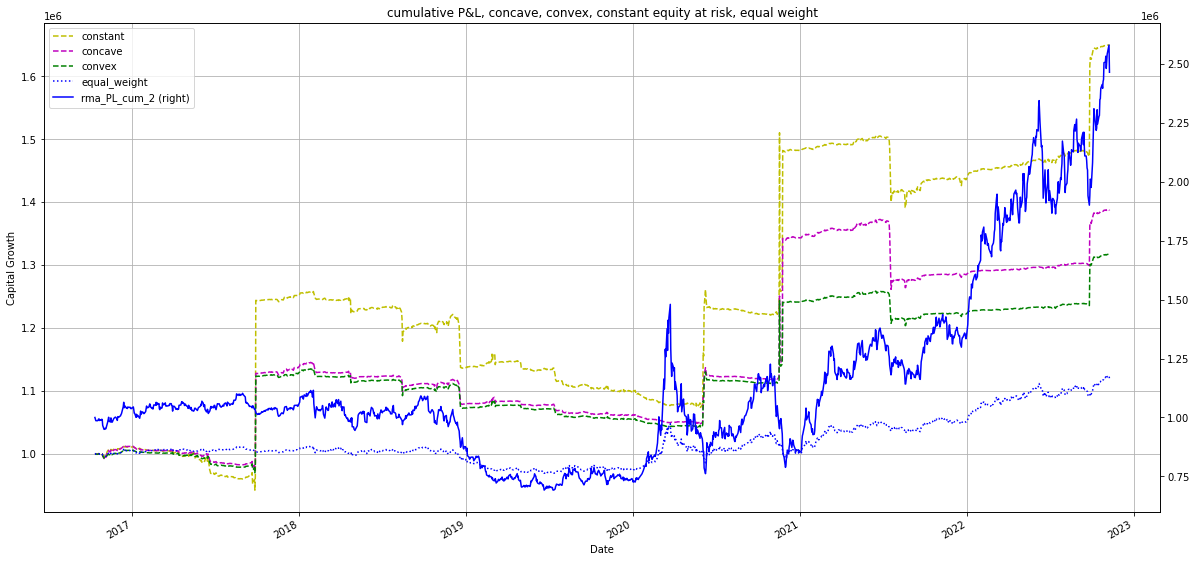

In [45]:
# Plot the position sizing algo
df[['constant','concave','convex','equal_weight', 'rma_PL_cum_2']].plot(figsize = (20,10), grid=True,
    style=['y--','m--','g--','b:', 'b'],secondary_y= 'rma_PL_cum_2',ylabel='Capital Growth',
title= 'cumulative P&L, concave, convex, constant equity at risk, equal weight');

Reinvesting everything (Cumulative P&L) seems to be performing best followed by the 
constant equity-at-risk scheme. 

This perhaps also shows that inserting a stop loss to limit damage is counterproductive. The strategy in its raw form without a trailing stop loss appears to capture the trend better.

As a reminder reinvesting here is the strategy in its raw form without any stop loss conditions. 

You reinvest every profit back into the strategy but do not add nor withdraw additional capital, however, in case of a loss. 

In plain english, you just let the strategy do its thing.




* Some Performance Metrics

 Functions:

                     - rolling_sharpe :   Calculates rolling sharpe ratio 
                                          over specified window.(result is annualized)

                     - expanding_sharpe:  Calculates cumulative sharpe ratio 
                                          over specified window.(result is annualized)

                     - robustness_score: Combines in a single metric the 
                                         Grit Index, Common Sense Ratio and
                                         Van Tharp's SQN.

In [47]:
# get risk free returns (Scale down by dividing by the product of 
# 100 and the maturity length in days)

#  Note the data goes only till 2022-07-15, Quandl discontinued the service

r_f= quandl.get('FRED/DGS3MO').squeeze()
treasury_days = 91
df['r_f'] =r_f/(100*treasury_days) 

# Note the scaling down is to get the risk free rate
# expressed in the approximate daily yield of the 3 month Treasury.

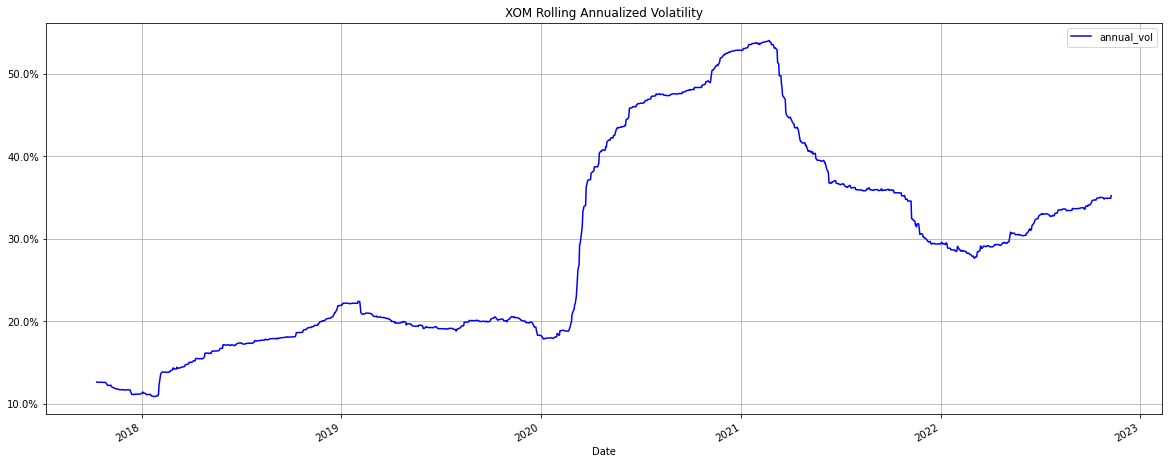

In [48]:
# Compute Annualized Rolling Volatility
window= 252
df['annual_vol'] = (rma_log_returns.rolling(window).std(ddof=0)* window**0.5)*100

ax =df[window:][['annual_vol'] ].plot(figsize = (20,8),
                        style = ['b',],grid=True,secondary_y='rg_cumul', 
        title = str(ticker)+' Rolling Annualized Volatility');
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

 It is obvious the strategy's returns become very volatile after 2020

In [49]:
#  Calculate Annualized Sharpe Ratios : Rolling and Expanding
#  Note expanding is just the cumulative sharpe

In [50]:
def rolling_sharpe(returns, r_f, window):
    avg_returns = returns.rolling(window).mean()
    std_returns = returns.rolling(window).std(ddof=0)
    r_f= r_f.rolling(window).mean()
    return (avg_returns - r_f) / std_returns

def expanding_sharpe(returns, r_f):
    avg_returns = returns.expanding().mean()
    std_returns = returns.expanding().std(ddof=0)
    r_f =r_f.expanding().mean()
    return (avg_returns - r_f) / std_returns

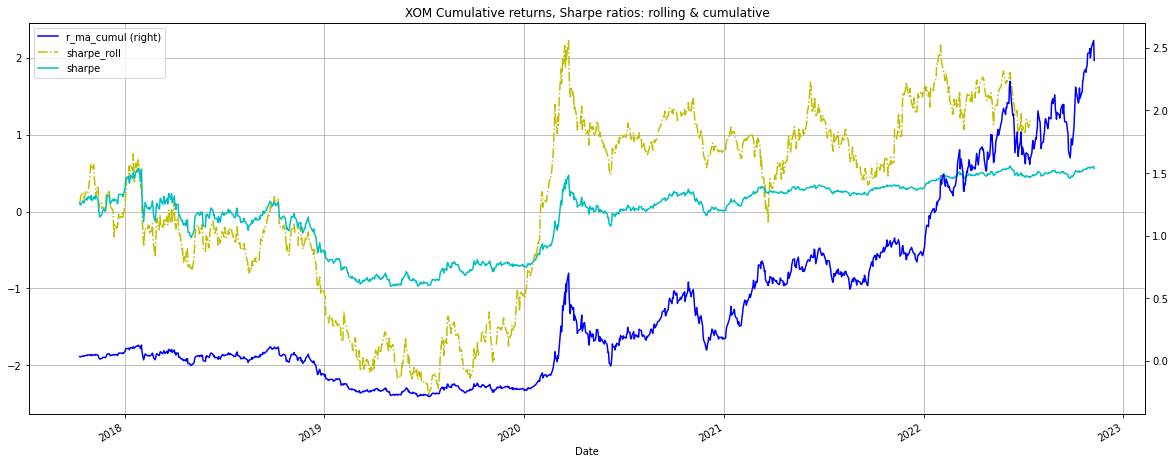

In [51]:
window= 252
df['sharpe_roll'] = rolling_sharpe(returns= rma_log_returns, r_f= r_f/(100*treasury_days), window= window) * window**0.5

df['sharpe']= expanding_sharpe(returns= rma_log_returns,r_f= df['r_f']) * window**0.5

df[window:][['r_ma_cumul','sharpe_roll','sharpe'] ].plot(figsize = (20,8),
             style = ['b','y-.','c'],grid=True, secondary_y='r_ma_cumul',                                 
        title = str(ticker)+' Cumulative returns, Sharpe ratios: rolling & cumulative'); 

In [52]:
# Risk Metrics -  Grit, Commonsense Ratio and Van Tharp's SQN

While not assessed individually, below is a broad idea of what each risk metric
seeks to capture:
    
* Grit Index :   
             Measures downside risk by roughly speaking taking 
             the ratio of cumulative performance to cumulative drawdowns.
             
             Laurent Bernut in his book, Algo. Short Selling,
             shows you can approximate the cumulative drawdowns by 
             taking the cumulative sum of the square root of squared drawdowns.
             Kind of like a pseudo-integral from calculus.
        
             Anyways, the metric seeks to show how performance is affected by drawdowns 
             for the strategy.
             
             For an ideal strategy you would want 
             this ratio to be fairly stable, positive and be reducing over time.
                

* Common Sense Ratio : 
            This is the profit ratio(pr) *  tail ratio(tr), where
        
PR =  Sum of positive returns/ (Sum of negative returns)


TR = Absolute value of ratio between returns at the upper quantile of the returns distribution and returns at the lower quantile. 

Example suppose the 95th quantile of your best months has been +6%. The 5% of your worst months has been -2%. Then your tail ratio is |6%/-2%| = 3
     
Ideally you want your CSR > 1 which means your strategy not vulnerable to shocks. If CSR <0.5, the strategy is unlikely to recover from a serious shock.

* Van Tharp's System Quality Number :
           T-stat calculated by  
            (number of trading signals^1/2) * trading_edge/ trading_edge.std
        
           In plain english, it is the ratio
           your system’s profitability to its consistency. This ratio 
           scaled by the square root of the number of trades your system generates.
            
           Consistency here means how much does your system’s profitability/  
           trading_edge change over time.
           (Its standard deviation).

In [53]:
def expanding_profits(returns): 
    profit_roll = returns.copy() 
    profit_roll[profit_roll < 0] = 0 
    profit_roll_sum = profit_roll.expanding().sum().fillna(method='ffill') 
    return profit_roll_sum 
 
def expanding_losses(returns): 
    loss_roll = returns.copy() 
    loss_roll[loss_roll > 0] = 0 
    loss_roll_sum =    loss_roll.expanding().sum().fillna(method='ffill') 
    return loss_roll_sum 

def profit_ratio(profits, losses):    
    pr = profits.fillna(method='ffill') / abs(losses.fillna(method='ffill'))
    return pr

def expanding_tail_ratio(cumul_returns, percentile,limit):
    left_tail = np.abs(cumul_returns.expanding().quantile(percentile))
    right_tail = cumul_returns.expanding().quantile(1 - percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail,limit),-limit)
    return tail

def common_sense_ratio(pr,tr):
    return pr * tr     # tr = tail ratio

In [54]:
'''
ulcer = square root of cumulative squared drawdown
drawdown = cumulative returns - peak returns over the cumulative period.

cumulative period = successive addition of time periods
eg. yesterday + today = cumulative period of 2 days
    yesterday + today + tomorrow = 3 days
'''
def expanding_grit(cumul_returns):
    tt_peak = cumul_returns.expanding().max()
    drawdown_squared = (cumul_returns - tt_peak) ** 2
    ulcer = drawdown_squared.expanding().sum() ** 0.5
    return cumul_returns / ulcer

def expectancy(win_rate,avg_win,avg_loss):  
    # win% * avg_win% - loss% * abs(avg_loss%) 
    return win_rate * avg_win + (1-win_rate) * np.abs(avg_loss)

def t_stat(signal_count, trading_edge): 
    sqn = (signal_count ** 0.5) * trading_edge / trading_edge.std(ddof=0) 
    return sqn

In [55]:
df['grit'] = expanding_grit(cumul_returns= df['r_ma_cumul'])

df['pr'] = profit_ratio(profits= expanding_profits(returns= rma_log_returns), 
                             losses= expanding_losses(returns = rma_log_returns))


df['tr'] = expanding_tail_ratio(cumul_returns= df['r_ma_cumul'], percentile= 0.05,limit=5)

df['csr'] = common_sense_ratio(pr= df['pr'],tr= df['tr'])

In [56]:
# Trade Count
df['trades'] = df.loc[(df['rma_' + str(days)].diff() !=0) & (pd.notnull(df['rma_' + str(days)])),'rma_' + str(days)].abs().cumsum()
signal_count = df['trades'].fillna(method='ffill')

# Cumulative t-stat
rma_win_count = rma_log_returns[rma_log_returns>0].expanding().count().fillna(method='ffill')
rma_count = rma_log_returns[rma_log_returns!=0].expanding().count().fillna(method='ffill')

win_rate = (rma_win_count / rma_count).fillna(method='ffill')
avg_win = expanding_profits(returns= rma_log_returns) / rma_count
avg_loss = expanding_losses(returns= rma_log_returns) / rma_count

df['sqn'] = t_stat(signal_count, df['trading_edge'])

1. The metrics are however, combined to come up with a composite score.
           
The composite score is the product of the above metrics
divided by the product of each of their first non-negative values.

The composite score is referred to in the code as robustness_score.

A strategy is robust if the robustness_score > 0 and appears to be increasing over time.

Robust here means the strategy 
-  Presents frequent favorable tradeable opportunities (thanks to the SQN):

 Remember Van Thorp's SQN roughly speaking, measures the system's profitability(trading edge) to its consistency (std of trading edge). Favorable here means the strategy has a positive trading edge, little std and generates a frequent number of trades.
 

-  Has acceptable drawdowns  (thanks to the Grit Index):

  Acceptable means the cumulative returns outweigh your cumulative drawdowns.

-  Generates decent returns  (thanks to the CSR):

  Remember CSR is the Profit Ratio(PR) times the Tail Ratio(TR). Decent returns
here means the strategy has a CSR >0.5 and is unlikely to be derailed by left tail 
events.

In [57]:
def robustness_score(grit,csr,sqn): 
    start_date = max(grit.index[5],
               csr.index[5],
               sqn.index[5])
    score = grit * csr * sqn / (grit[start_date] * csr[start_date] * sqn[start_date])
    return score

df['score'] = robustness_score(grit = df['grit'],csr = df['csr'],sqn = df['sqn'])

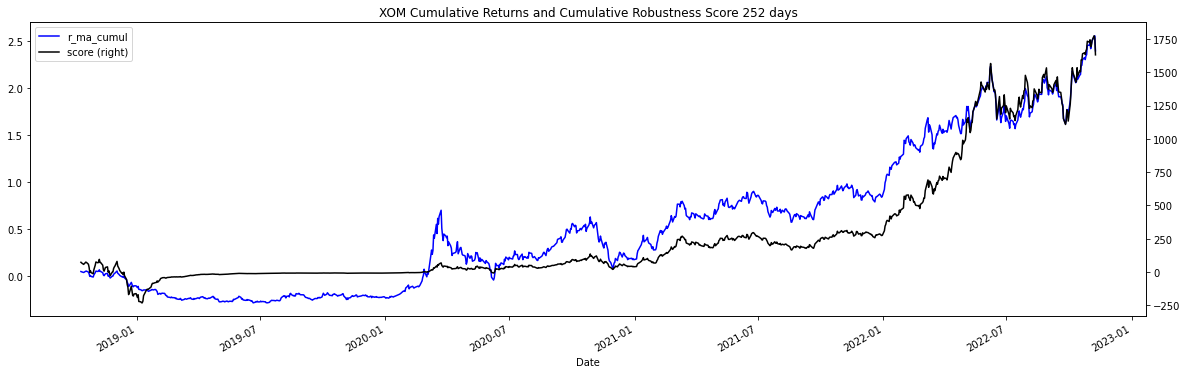

In [58]:
# Plot the Robustness Cumulative Returns and Cumulative Robustness Score
df[window*2:][['r_ma_cumul','score']].plot(
    secondary_y= ['score'],figsize=(20,6),style = ['b','k','k-.'], 
 title= str(ticker)+' Cumulative Returns and Cumulative Robustness Score '+ str(window)+' days');

The strategy appears to go through periods where it is robust and not. It is robust in its early stages but doesn't show signs of strengthening. This strengthening happens only later in late-2020.


Again robust here means the strategy
-  Presents frequent favorable tradeable opportunities (thanks to the SQN):

 Remember Van Thorp's SQN roughly speaking, measures the system's profitability(trading edge) to its consistency (std of trading edge). Favorable here means the strategy has a positive trading edge, little std and generates a frequent number of trades.
 

-  Has acceptable drawdowns  (thanks to the Grit Index):


  Acceptable means the cumulative returns outweigh your cumulative drawdowns.

-  Generates decent returns  (thanks to the CSR):

  Remember CSR is the Profit Ratio(PR) times the Tail Ratio(TR). Decent returns
here means the strategy has a CSR >0.5 and is unlikely to be derailed by left tail 
events.

 Code Organization & Functions - Section 6: Drawdown on Strategy


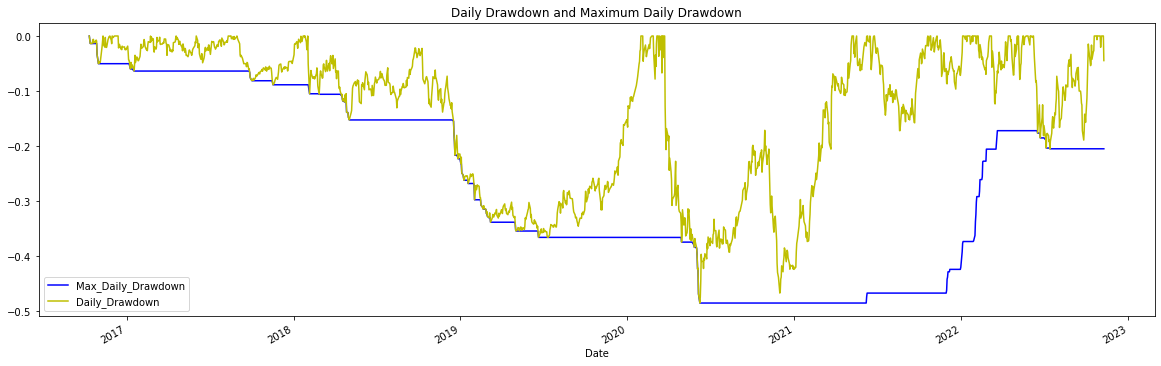

In [59]:
# Calculate the max drawdown in the past window days for each day in the series.
# min_periods = 1 to allow the first 252 days data have an expanding window

Roll_Max = df['rma_PL_cum_2'].rolling(window, min_periods=1).max()
df['Daily_Drawdown'] = df['rma_PL_cum_2']/Roll_Max - 1.0

# Calculate minimum (negative) daily drawdown in that window.
df['Max_Daily_Drawdown'] = df['Daily_Drawdown'].rolling(window, min_periods=1).min()

# Plot the results
df[['Max_Daily_Drawdown', 'Daily_Drawdown']].plot(
     figsize=(20,6),style=['b','y'], 
    title= 'Daily Drawdown and Maximum Daily Drawdown');

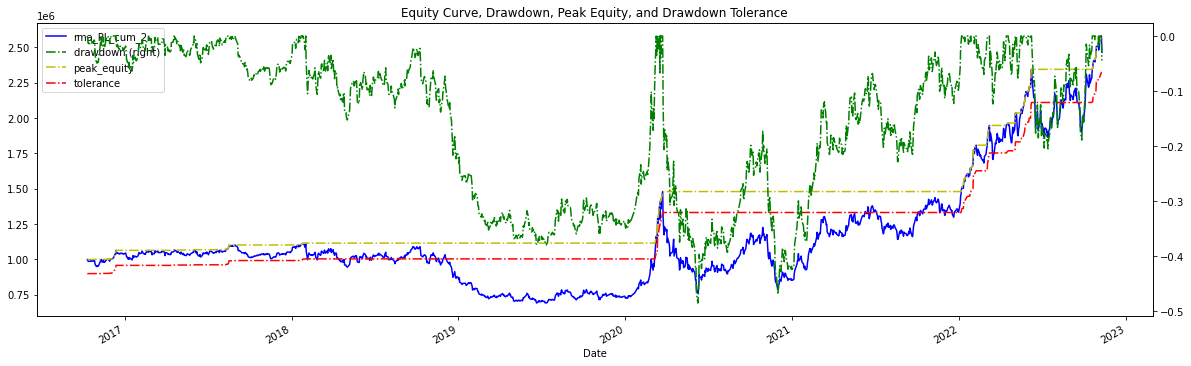

In [60]:
dd_tolerance = -0.1 # Drawdown tolerance
# Peak_equity = Cumulative Max of Deployed Capital

df['peak_equity'] = df['rma_PL_cum_2'].cummax()
df['tolerance']= df['peak_equity']*(1+dd_tolerance)
df['drawdown'] = df['rma_PL_cum_2']/df['rma_PL_cum_2'].cummax()- 1.0

df[['rma_PL_cum_2','drawdown', 'peak_equity','tolerance']].plot(
     figsize=(20,6),style=['b','g-.','y-.','r-.'], secondary_y=['drawdown'],
    title= 'Equity Curve, Drawdown, Peak Equity, and Drawdown Tolerance');

Note the Equity Curve is the change in value of the trading capital. 
(It is the blue line - scale is on the right)

* Code Organization & Functions - Section 7:
        - Summary  (Strategy Stats)  

In [65]:
# Max Drawdown Date
ddr_max = df['Max_Daily_Drawdown'].idxmin().to_pydatetime()

# identifies highs for which the drawdowns must be zero
ddr= df[df['Daily_Drawdown']==0]
ddr = ddr['Daily_Drawdown']
temp = ddr

# time between all highs
periods = (temp.index[1:]- temp.index[:-1])

# longest drawdown period in days
t_per = periods.max().days
         
# Sharpe in the last 252 days
sr_1=df['sharpe_roll'].dropna()[-252:].mean()

# Cumulative returns
ret = df['r_ma_cumul'][-1] - 1

# Beta - S&P as benchmark
bm_ticker = '^GSPC' #S&P
params = ['2015-12-30', None]
start_, end_ = [params[h] for h in range(len(params))]
benchmark =  round(yf.download(tickers= bm_ticker,start= start_, end = end_, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None),2)['Close']
df['bm'] = benchmark.pct_change()
x =  np.array(df['r_ma_returns'].dropna()).reshape((-1,1))
y =  np.array(df['bm'].dropna()[1:])
model = LinearRegression().fit(x,y)

start =df['rma_' + str(days)].index[0].to_pydatetime()

# End is last available cumulative sharpe
# This is where the Treasury data ends
end = df['sharpe_roll'].dropna().index[-1]


# time between first and last trading signals
period = end.year - start.year

p1 = end.strftime("%Y-%m-%d")

# Annual Vol - Average
vlty = df['annual_vol'].mean()

# Average VaR 
perc = 5.0
df['VaR'] = scs.scoreatpercentile(df['rma_PL_cum_2']*rma_log_returns,perc)
VaR = df['VaR'].mean()

# cagr = compounded annual growth rate
cagr = (df['rma_PL_cum_2'][p1] / df['rma_PL_cum_2'][0])**(1/period)-1

# Overall sharpe since the strategy became active
rf= r_f/100
sr = (cagr - rf.mean())/rf.std()

# how much your capital appreciated
profits = (df['rma_PL_cum_2'][p1])-(df['rma_PL_cum_2'][0])



[*********************100%***********************]  1 of 1 completed


In [80]:
print('Strategy Summary - Given starting capital of $1,000,000')
print('---'*15)
display(pd.Series({
    'Start date': (start.year , start.month , start.day),
    'End date': (end.year , end.month , end.day),
    'Sharpe Ratio (Start Date - End Date)': "{:.2f}".format(sr),
    'Sharpe Ratio (Last 252 days)': "{:.2f}".format(sr_1),
    'CAGR' : "{:.2%}".format(cagr),
    'Annual Volatility' :     "{:.2%}".format(vlty/100),
    'Max Daily Drawdown' :    "{:.2%}".format(df['Max_Daily_Drawdown'].min()),
    'Date of Max Daily Drawdown' :(ddr_max.year, ddr_max.month, ddr_max.day),
    'Longest Drawdown Period(in days)' : t_per,
    'Longest Drawdown Period(in trading days)' : round(t_per-2*113,0),
    'Average Daily VaR (95% Confidence Level)' : "${:0,.2f}".format(-VaR),
    'Total Profits' : "${:0,.2f}".format(profits),
    'Alpha' : "{:.4f}".format(model.intercept_),
    'Beta' : "{:.4f}".format(model.coef_[0]),
    'Win Rate'    : "{:.2%}".format(cum_win_rate[-1]),
    'Average Win' : "{:.2%}".format(cum_avg_win[-1]),
    'Loss Rate' : "{:.2%}".format(cum_loss_rate[-1]),
    'Average Loss' : "{:.2%}".format(cum_avg_loss[-1]),
}))

print('* Note: I assume you position size using the Cumulative P&L scheme.')
print('* Again, this is the no rebalancing/adjustment scheme.')
print('* VaR = Value-at-Risk')

hold = (df['Close'][p1]/df['Close'][0])**(1/period)-1
print('')
print(' As a side note if you had just bought and held, you would only have made ' +
     "{:.2%}".format(hold) + ' annually')

Strategy Summary - Given starting capital of $1,000,000
---------------------------------------------


Start date                                  (2016, 10, 11)
End date                                     (2022, 7, 15)
Sharpe Ratio (Start Date - End Date)                  2.31
Sharpe Ratio (Last 252 days)                          1.22
CAGR                                                11.24%
Annual Volatility                                   28.99%
Max Daily Drawdown                                 -48.54%
Date of Max Daily Drawdown                    (2020, 6, 8)
Longest Drawdown Period(in days)                       729
Longest Drawdown Period(in trading days)               503
Average Daily VaR (95% Confidence Level)        $35,423.98
Total Profits                                  $895,185.24
Alpha                                               0.0006
Beta                                               -0.1570
Win Rate                                            51.64%
Average Win                                          0.68%
Loss Rate                                           45.4

* Note: I assume you position size using the Cumulative P&L scheme.
* Again, this is the no rebalancing/adjustment scheme.
* VaR = Value-at-Risk

 As a side note if you had just bought and held, you would only have made 4.33% annually
